<a href="https://colab.research.google.com/github/naomifridman/Introduction_to_deep_learning/blob/master/lec4_intro_convolutional_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lec 4
### Introduction to Deep Learning
# Intuition - Convolutional Neural networks CNN

In [ ]:
import os

if not os.path.isdir('Introduction_to_deep_learning'):
    !git clone https://github.com/naomifridman/Introduction_to_deep_learning.git

In [ ]:
#!rm -r Introduction_to_deep_learning

In [ ]:
import numpy as np
import Introduction_to_deep_learning.utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss
from keras.datasets import mnist
import matplotlib.pyplot as plt
import Introduction_to_deep_learning.matplotlib_utils as umplot
%matplotlib inline  

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


## Load the Hand Written Digit Data Mnist 

In [ ]:
from sklearn.utils import shuffle

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = shuffle(x_train, y_train , random_state=0)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


Lets view some images and labels:

In [ ]:
x_train.shape

(60000, 28, 28)

Lables are: [1 2 2 9 3 6 9 8 7 0 0 3 7 0 6]


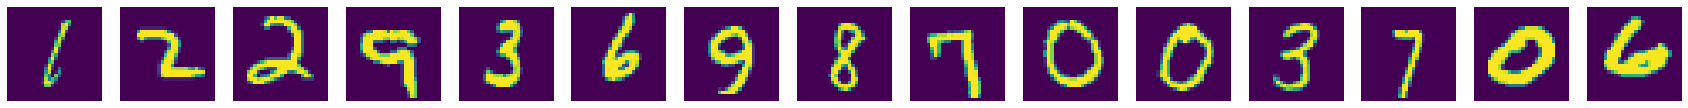

In [ ]:
print('Lables are:', y_train[15:30])
uplot.show_list_images(x_train[15:30])

Lets choose 2 images of as example to our discussion:

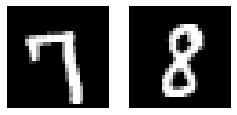

In [ ]:
img7 = x_train[23]
img8 = x_train[97]
umplot.show_list_images([img7,img8])

### Convolution as feature detector
Convolution is actually a correlation between small part of the image and the filter. We can build a filter that represent a specific feature, horizontal edge for example. Mow we slide the filter along the image, and calculate the "response" or the correlation to of the filter to specific parts in the image. The output map of those responses, highlight the areas in the image that contain features which are correlated with the filter.<br>
#### Define a filter, and convolve it with the given images.
Lets start with a filter that detect horizontal edges.

In [ ]:
def conv2D(image, conv_filter):
    # as a demo code, here we ignore the shape check
    x_row, x_col = image.shape
    k_row, k_col = conv_filter.shape
    ret_row, ret_col = x_row - k_row + 1, x_col - k_col + 1
    ret = np.zeros((ret_row, ret_col))
    for y in range(ret_row):
        for x in range(ret_col):
            sub = image[y : y + k_row, x : x + k_col]
            ret[y,x] = np.sum(sub * conv_filter)
    return ret

def conv2D_list(images, conv_filter):
    ret=[]
    for im in images:
        ret.append(conv2D(im, conv_filter))
    return ret

In [ ]:
from importlib import reload  # Python 3.4+ only.
import Introduction_to_deep_learning.matplotlib_utils as umplot
umplot = reload(umplot)

## Apply - Horizontal Sobol Kernal

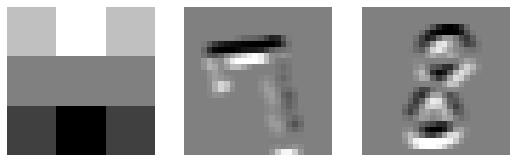

In [ ]:
horizontal_sobol=np.array([[1, 0,-1],
       [2,0, -2],
       [1,0, -1]]).T

printmd('## Apply - Horizontal Sobol Kernal')

conv_image = conv2D_list([img7, img8], horizontal_sobol)
umplot.show_list_images([horizontal_sobol, conv_image[0], conv_image[1]], lsize=3)

The transpose of this filter, will be a filter as well, that will detect the vertical edges.

## Apply - Transpose of Horizontal Sobol Kernal

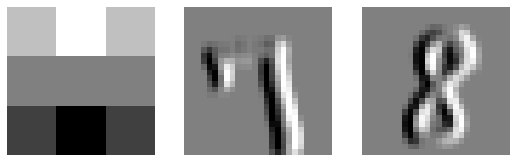

In [ ]:
conv_image = conv2D_list([img7, img8], horizontal_sobol.T)
printmd('## Apply - Transpose of Horizontal Sobol Kernal')
umplot.show_list_images([horizontal_sobol, conv_image[0], conv_image[1]], lsize=3)

This way we can continue and design different features, to detect diagonals, specific corners,etc. Lets design few more edges.

In [ ]:
# Horizontal line detector
conv_filter = []
conv_filter.append(horizontal_sobol)
conv_filter.append(horizontal_sobol.T)

In [ ]:
# 45 degree line detector
cfilter=np.array([[2,-1,-1],
       [-1,2,-1],
       [-1,-1,2]])
conv_filter.append(cfilter)
cfilter=np.array([[-1,-1,2],
       [-1,2,-1],
       [2,-1,-1]])
conv_filter.append(cfilter)

In [ ]:
cfilter=np.array([[0,-1,0],
       [-1,4,-1],
       [0,-1,0]])
conv_filter.append(cfilter)

Lets view the filters we built and their convolution with the example images. 

## Apply list of kernals

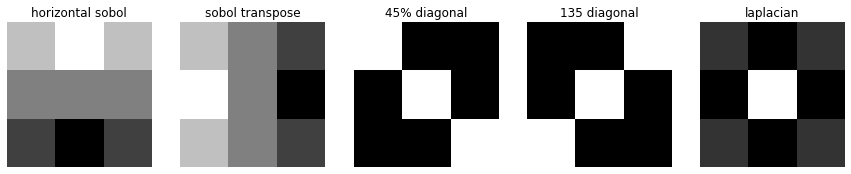

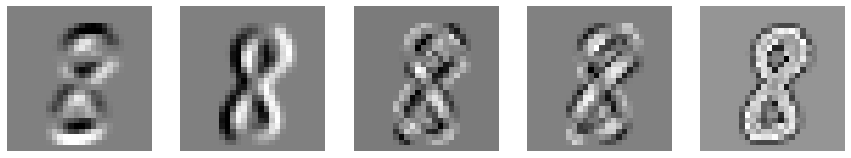

In [ ]:
conv_image =[]
for f in conv_filter:
    conv_image.append(conv2D(img8, f))
printmd('## Apply list of kernals')
umplot.show_list_images(conv_filter, titles=['horizontal sobol','sobol transpose',
                                            '45% diagonal','135 diagonal','laplacian'], lsize=3)
umplot.show_list_images(conv_image, lsize=3)

## Apply list of kernals

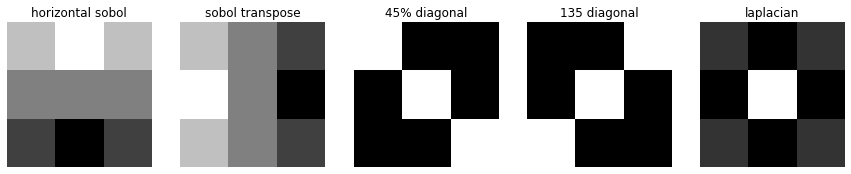

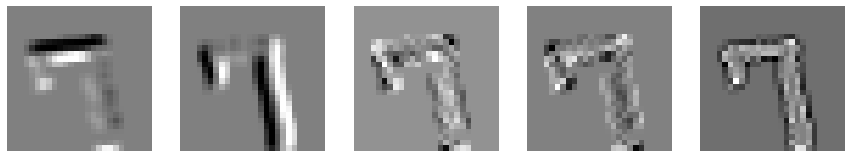

In [ ]:
conv_image =[]
for f in conv_filter:
    conv_image.append(conv2D(img7, f))
printmd('## Apply list of kernals')
umplot.show_list_images(conv_filter, titles=['horizontal sobol','sobol transpose',
                                            '45% diagonal','135 diagonal','laplacian'], lsize=3)
umplot.show_list_images(conv_image, lsize=3)

### To collect the information from the feature map of each filter, we can run another set of filter's on the feature map's.
Lets view  the convolution of one of the filters with the feature map of the first step.

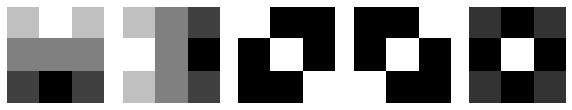

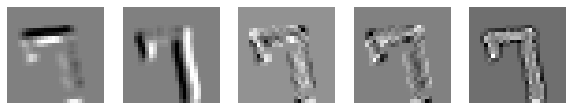

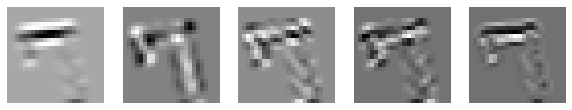

In [ ]:
conv_image7 =[]
for im in conv_image:
    conv_image7.append(conv2D(im, conv_filter[0]))
umplot.show_list_images(conv_filter)
umplot.show_list_images(conv_image)
umplot.show_list_images(conv_image7)

### The performance of a convolutional , relies on the right filters. 
So, the idea here is that :
#### Those filter's will be learn from the data, with the gradient decent method of decreasing the error
* backpropogation.

Up to here,we discussed the basic intuition to convolutional networks. lets start describing the scheme of building practical convolutional networks. Following are some basic definitions:

## 2D Convolution neural networks building blocks
### Stride parameter - sliding steps
Until now we slided the filter,with steps of 1. But we can slide the filter in larger steps. The size of the sliding step, is the stride parameter. Default value is 1.
### Padding parameter- Keep image size or decrease it
When we convolved a filter of size 3x3 with image size 28x28, the result was 26x26 image. If we don't want to decrease the size after each convolution, we can pad zeros for example, around the image,prior to convolution, to control the output size. Keras has "same" value for padding, that takes care that output size, will be the same as input.
### Convolution layer - a set of filters
Convolution layer, contain given number of filters, say F. each filter is convolving with the input image, all channels of it, and create feature map. So the output will be a stack of F feature maps, one per each filter. The size of the feature map's depends on the padding, stride and filter size.
### Maxpooling layer - down-sampling layer
Maxpooling layer, is a down-sampling layer. It helps prevent overfitting, and it decrease the size of the layer downwards to the number of classes we want to classify.<br>
In Maxpooling layer, we define a mask of size nxn, slide the mask over the feature maps, and choose the maximal number (maximal intensity pixel) in the mask.


### Basic structure of Convolutional neural network
* Input layer - the input image, with defined padding.
* convolution block's -which are built from convolution and maxpooling layers.
* Dense Block - built from dense and droput layers,usually applied on flatten convolution output. Last layer for classification task is usually Softmax.